In [64]:
import base64
from requests import post, get
import json


client_id = "05ba187e71a949f98361cfe8272c8a8c"
client_secret = "3de79f6ca9124a8785339527c0241b01"

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
        
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

def get_auth_header(token):
    return {"Authorization": "Bearer " + token}


# 得出美国地区排名前20的歌曲风格
def get_genres(access_token, country='US', limit=20, offset=0):
    genres_url = "https://api.spotify.com/v1/browse/categories"
    headers = get_auth_header(access_token)

    params = {
        "country": country,
        "limit": limit,
        'offset': offset
    }

    response = get(genres_url, headers=headers, params=params)
    genres_data = response.json()
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]

    return genres

genres = []
token = get_token()


result = get_genres(token)
for genre_id, genre in result:
    genres.append(f'genre:"{genre}"')

print(genres)



['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']


In [65]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = "05ba187e71a949f98361cfe8272c8a8c"
client_secret = "3de79f6ca9124a8785339527c0241b01"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = get_token()


In [66]:
import pandas as pd
import time

# 计算每个歌曲风格排名前50的歌曲
def creat_frame(quert_list, limit=50):
    # 初始化数据库
    data = {
        'Track ID': [],
        'Track name': [],
        'Artist': [],
        'Popularity': [],
        'Release year': [],
        'Genres': []
    }
    
    for query in quert_list:
        search_result = sp.search(query, limit=limit, type='track')
        tracks = search_result['tracks']['items']

        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track name'].append(track['name'])
            data['Artist'].append(track['artists'][0]['name'])
            data['Popularity'].append(track['popularity'])
            data['Release year'].append(track['album']['release_date'][:4])
            data['Genres'].append(query)
            


    df = pd.DataFrame(data)
    return df

genres = ['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']
df = creat_frame(genres, limit=50)


In [8]:
df

,Track ID,Track name,Artist,Popularity,Release year,Genres
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop"""
1,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,93,2023,"genre:""Hip-Hop"""
2,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),Drake,91,2023,"genre:""Hip-Hop"""
3,68Dni7IE4VyPkTOH9mRWHr,No Role Modelz,J. Cole,91,2014,"genre:""Hip-Hop"""
4,4rXLjWdF2ZZpXCVTfWcshS,fukumean,Gunna,93,2023,"genre:""Hip-Hop"""
...,...,...,...,...,...,...
695,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming"""
696,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming"""
697,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming"""
698,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,56,2021,"genre:""Gaming"""


In [10]:
df['Genres'].value_counts()

genre:"Hip-Hop"             50
genre:"Pop"                 50
genre:"Country"             50
genre:"Latin"               50
genre:"Rock"                50
genre:"Workout"             50
genre:"R&B"                 50
genre:"Dance/Electronic"    50
genre:"Indie"               50
genre:"Mood"                50
genre:"Sleep"               50
genre:"Regional Mexican"    50
genre:"Chill"               50
genre:"Gaming"              50
Name: Genres, dtype: int64

In [11]:
def get_audio_features(track_ids):
    features_list = []
    
    for i in range(0, len(track_ids), 50):
        batch = track_ids[i:i + 50]
        features_results = sp.audio_features(batch)
        features_list += features_results
    return features_list

In [12]:
track_ids = df['Track ID'].tolist()
audio_features = get_audio_features(track_ids)

In [13]:
audio_features_df = pd.DataFrame(audio_features)


In [14]:
audio_features_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.943,0.558,2,-4.911,1,0.0568,0.002600,0.000002,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
1,0.663,0.670,8,-8.399,1,0.2710,0.046400,0.000089,0.2050,0.1380,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4
2,0.470,0.640,2,-7.779,1,0.3200,0.027700,0.000000,0.3820,0.2480,163.920,audio_features,7aqfrAY2p9BUSiupwk3svU,spotify:track:7aqfrAY2p9BUSiupwk3svU,https://api.spotify.com/v1/tracks/7aqfrAY2p9BU...,https://api.spotify.com/v1/audio-analysis/7aqf...,247444,4
3,0.690,0.521,10,-8.492,0,0.3390,0.324000,0.000000,0.0534,0.4940,100.028,audio_features,68Dni7IE4VyPkTOH9mRWHr,spotify:track:68Dni7IE4VyPkTOH9mRWHr,https://api.spotify.com/v1/tracks/68Dni7IE4VyP...,https://api.spotify.com/v1/audio-analysis/68Dn...,292799,4
4,0.847,0.622,1,-6.747,0,0.0903,0.119000,0.000000,0.2850,0.2200,130.001,audio_features,4rXLjWdF2ZZpXCVTfWcshS,spotify:track:4rXLjWdF2ZZpXCVTfWcshS,https://api.spotify.com/v1/tracks/4rXLjWdF2ZZp...,https://api.spotify.com/v1/audio-analysis/4rXL...,125040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.570,0.960,6,-1.986,0,0.0656,0.001390,0.829000,0.1370,0.1480,150.063,audio_features,4nCW3tSl82LPbmrrwYpF4b,spotify:track:4nCW3tSl82LPbmrrwYpF4b,https://api.spotify.com/v1/tracks/4nCW3tSl82LP...,https://api.spotify.com/v1/audio-analysis/4nCW...,227200,4
696,0.700,0.878,0,-5.133,1,0.0989,0.012200,0.000525,0.3200,0.3670,99.997,audio_features,3aYidIc6HUMrL1tFTmokSZ,spotify:track:3aYidIc6HUMrL1tFTmokSZ,https://api.spotify.com/v1/tracks/3aYidIc6HUMr...,https://api.spotify.com/v1/audio-analysis/3aYi...,176100,4
697,0.606,0.952,8,-2.004,1,0.2170,0.040300,0.000252,0.6650,0.3510,74.980,audio_features,4hAb4pbqgfgwraiHongYZR,spotify:track:4hAb4pbqgfgwraiHongYZR,https://api.spotify.com/v1/tracks/4hAb4pbqgfgw...,https://api.spotify.com/v1/audio-analysis/4hAb...,217787,4
698,0.486,0.872,10,-5.056,0,0.0425,0.045800,0.000054,0.2160,0.3990,174.985,audio_features,2bjtlNmO8Rf5Bl4rxNl3GJ,spotify:track:2bjtlNmO8Rf5Bl4rxNl3GJ,https://api.spotify.com/v1/tracks/2bjtlNmO8Rf5...,https://api.spotify.com/v1/audio-analysis/2bjt...,177782,4


In [15]:
# 合并两个表格
merged_df = df.merge(audio_features_df, left_on='Track ID', right_on='id', how='inner')
merged_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
1,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
2,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Pop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
3,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Pop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
4,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,93,2023,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,...,0.2050,0.1380,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming""",0.570,0.960,6,-1.986,...,0.1370,0.1480,150.063,audio_features,4nCW3tSl82LPbmrrwYpF4b,spotify:track:4nCW3tSl82LPbmrrwYpF4b,https://api.spotify.com/v1/tracks/4nCW3tSl82LP...,https://api.spotify.com/v1/audio-analysis/4nCW...,227200,4
774,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming""",0.700,0.878,0,-5.133,...,0.3200,0.3670,99.997,audio_features,3aYidIc6HUMrL1tFTmokSZ,spotify:track:3aYidIc6HUMrL1tFTmokSZ,https://api.spotify.com/v1/tracks/3aYidIc6HUMr...,https://api.spotify.com/v1/audio-analysis/3aYi...,176100,4
775,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming""",0.606,0.952,8,-2.004,...,0.6650,0.3510,74.980,audio_features,4hAb4pbqgfgwraiHongYZR,spotify:track:4hAb4pbqgfgwraiHongYZR,https://api.spotify.com/v1/tracks/4hAb4pbqgfgw...,https://api.spotify.com/v1/audio-analysis/4hAb...,217787,4
776,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,56,2021,"genre:""Gaming""",0.486,0.872,10,-5.056,...,0.2160,0.3990,174.985,audio_features,2bjtlNmO8Rf5Bl4rxNl3GJ,spotify:track:2bjtlNmO8Rf5Bl4rxNl3GJ,https://api.spotify.com/v1/tracks/2bjtlNmO8Rf5...,https://api.spotify.com/v1/audio-analysis/2bjt...,177782,4


In [16]:
# 去重处理
uni_df = merged_df.drop_duplicates(subset='Track ID', keep='first')

In [17]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
4,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,93,2023,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,...,0.2050,0.1380,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4
8,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),Drake,91,2023,"genre:""Hip-Hop""",0.470,0.640,2,-7.779,...,0.3820,0.2480,163.920,audio_features,7aqfrAY2p9BUSiupwk3svU,spotify:track:7aqfrAY2p9BUSiupwk3svU,https://api.spotify.com/v1/tracks/7aqfrAY2p9BU...,https://api.spotify.com/v1/audio-analysis/7aqf...,247444,4
12,68Dni7IE4VyPkTOH9mRWHr,No Role Modelz,J. Cole,91,2014,"genre:""Hip-Hop""",0.690,0.521,10,-8.492,...,0.0534,0.4940,100.028,audio_features,68Dni7IE4VyPkTOH9mRWHr,spotify:track:68Dni7IE4VyPkTOH9mRWHr,https://api.spotify.com/v1/tracks/68Dni7IE4VyP...,https://api.spotify.com/v1/audio-analysis/68Dn...,292799,4
13,4rXLjWdF2ZZpXCVTfWcshS,fukumean,Gunna,93,2023,"genre:""Hip-Hop""",0.847,0.622,1,-6.747,...,0.2850,0.2200,130.001,audio_features,4rXLjWdF2ZZpXCVTfWcshS,spotify:track:4rXLjWdF2ZZpXCVTfWcshS,https://api.spotify.com/v1/tracks/4rXLjWdF2ZZp...,https://api.spotify.com/v1/audio-analysis/4rXL...,125040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming""",0.570,0.960,6,-1.986,...,0.1370,0.1480,150.063,audio_features,4nCW3tSl82LPbmrrwYpF4b,spotify:track:4nCW3tSl82LPbmrrwYpF4b,https://api.spotify.com/v1/tracks/4nCW3tSl82LP...,https://api.spotify.com/v1/audio-analysis/4nCW...,227200,4
774,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming""",0.700,0.878,0,-5.133,...,0.3200,0.3670,99.997,audio_features,3aYidIc6HUMrL1tFTmokSZ,spotify:track:3aYidIc6HUMrL1tFTmokSZ,https://api.spotify.com/v1/tracks/3aYidIc6HUMr...,https://api.spotify.com/v1/audio-analysis/3aYi...,176100,4
775,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming""",0.606,0.952,8,-2.004,...,0.6650,0.3510,74.980,audio_features,4hAb4pbqgfgwraiHongYZR,spotify:track:4hAb4pbqgfgwraiHongYZR,https://api.spotify.com/v1/tracks/4hAb4pbqgfgw...,https://api.spotify.com/v1/audio-analysis/4hAb...,217787,4
776,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,56,2021,"genre:""Gaming""",0.486,0.872,10,-5.056,...,0.2160,0.3990,174.985,audio_features,2bjtlNmO8Rf5Bl4rxNl3GJ,spotify:track:2bjtlNmO8Rf5Bl4rxNl3GJ,https://api.spotify.com/v1/tracks/2bjtlNmO8Rf5...,https://api.spotify.com/v1/audio-analysis/2bjt...,177782,4


In [18]:
columns_to_drop = ['id', 'uri', 'track_href', 'analysis_url', 'type']
uni_df = uni_df.drop(columns=columns_to_drop, axis=1)

In [19]:
uni_df.reset_index(drop=True, inplace=True)

In [39]:
uni_df

,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,1,0.0568,0.002600,0.000002,0.0937,0.6060,104.983,138411,4
1,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,1,0.2710,0.046400,0.000089,0.2050,0.1380,136.952,260111,4
2,"genre:""Hip-Hop""",0.470,0.640,2,-7.779,1,0.3200,0.027700,0.000000,0.3820,0.2480,163.920,247444,4
3,"genre:""Hip-Hop""",0.690,0.521,10,-8.492,0,0.3390,0.324000,0.000000,0.0534,0.4940,100.028,292799,4
4,"genre:""Hip-Hop""",0.847,0.622,1,-6.747,0,0.0903,0.119000,0.000000,0.2850,0.2200,130.001,125040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,"genre:""Gaming""",0.570,0.960,6,-1.986,0,0.0656,0.001390,0.829000,0.1370,0.1480,150.063,227200,4
659,"genre:""Gaming""",0.700,0.878,0,-5.133,1,0.0989,0.012200,0.000525,0.3200,0.3670,99.997,176100,4
660,"genre:""Gaming""",0.606,0.952,8,-2.004,1,0.2170,0.040300,0.000252,0.6650,0.3510,74.980,217787,4
661,"genre:""Gaming""",0.486,0.872,10,-5.056,0,0.0425,0.045800,0.000054,0.2160,0.3990,174.985,177782,4


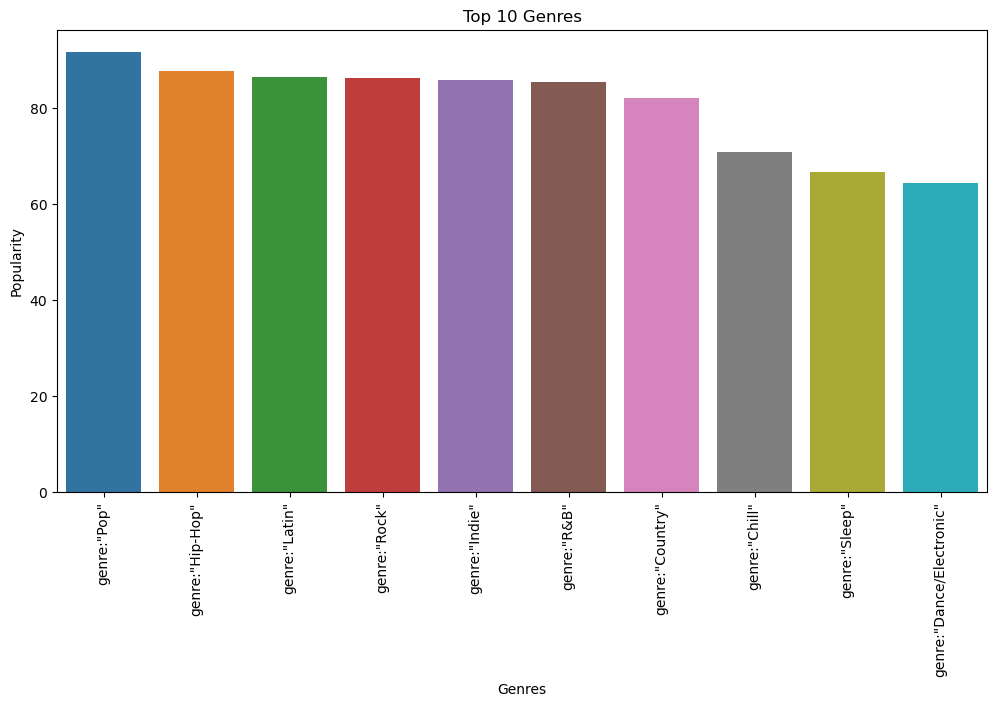

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average score for each genre
genre_popularity = uni_df.groupby('Genres')['Popularity'].mean().reset_index()
# Average scores obtained by sorting in descending order
genre_popularity = genre_popularity.sort_values('Popularity', ascending=False)
# Selection of top 10 data
genre_popularity = genre_popularity.head(10)
# Setting the canvas size
plt.figure(figsize=(12,6))
# Plotting histograms, setting axes and values
sns.barplot(x='Genres', y='Popularity', data=genre_popularity)
# Setting the title
plt.title('Top 10 Genres')
# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

plt.show()



In [45]:
columns_to_drop = ['Track ID', 'duration_ms', 'time_signature']

filtered_df = uni_df.drop(columns=columns_to_drop)

print(filtered_df.head())

                             Track name       Artist  Popularity Release year  \
0                           Lovin On Me  Jack Harlow          97         2023   
1                    IDGAF (feat. Yeat)        Drake          93         2023   
2  First Person Shooter (feat. J. Cole)        Drake          91         2023   
3                        No Role Modelz      J. Cole          91         2014   
4                              fukumean        Gunna          93         2023   

            Genres  danceability  energy  key  loudness  mode  speechiness  \
0  genre:"Hip-Hop"         0.943   0.558    2    -4.911     1       0.0568   
1  genre:"Hip-Hop"         0.663   0.670    8    -8.399     1       0.2710   
2  genre:"Hip-Hop"         0.470   0.640    2    -7.779     1       0.3200   
3  genre:"Hip-Hop"         0.690   0.521   10    -8.492     0       0.3390   
4  genre:"Hip-Hop"         0.847   0.622    1    -6.747     0       0.0903   

   acousticness  instrumentalness  liveness 

C:\Users\samuel\AppData\Local\Temp\ipykernel_18420\745706534.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Release year'] = df['Release year'].astype(int)


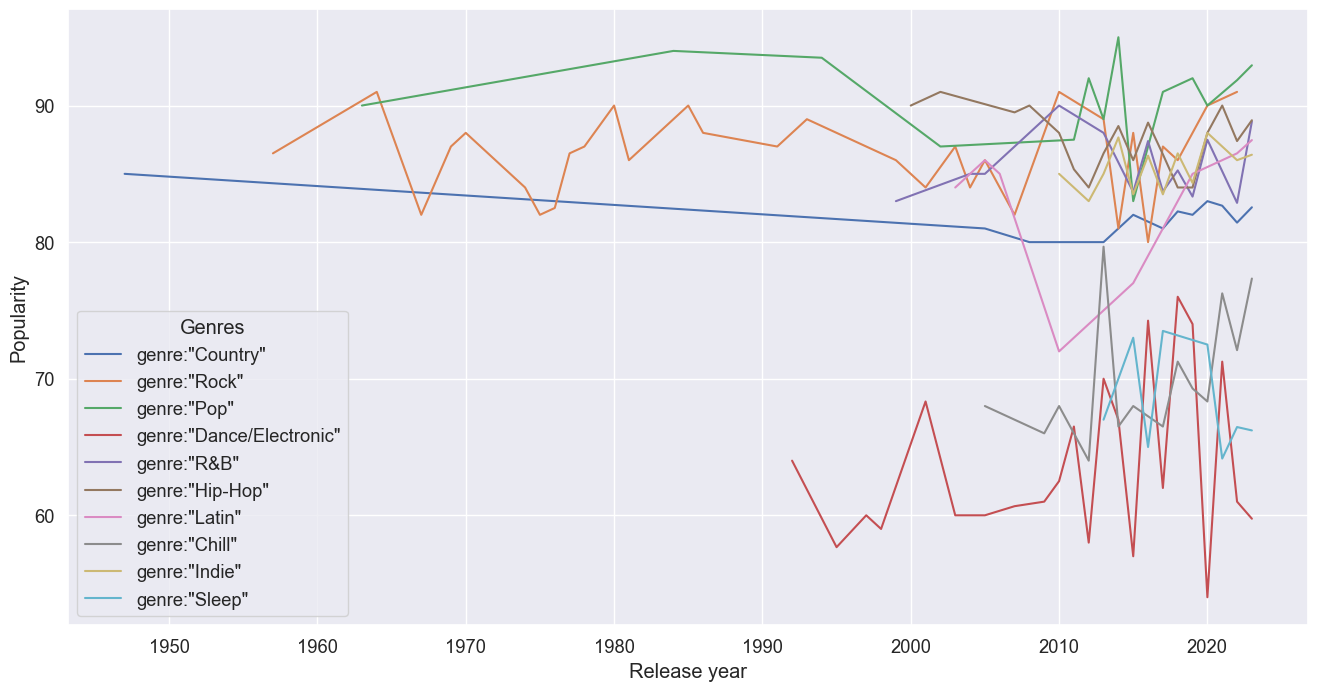

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average score for each genre
genre_popularity = filtered_df.groupby('Genres')['Popularity'].mean().reset_index()
# Average scores obtained by sorting in descending order
genre_popularity = genre_popularity.sort_values('Popularity', ascending=False)
# Selection of top 10 data
top_10 = genre_popularity.head(10)['Genres'].values

df = filtered_df[filtered_df['Genres'].isin(top_10)]

df['Release year'] = df['Release year'].astype(int)

year_genre_popularity = df.groupby(['Release year', 'Genres'])['Popularity'].mean().reset_index()

plt.figure(figsize=(16,8))
sns.lineplot(x='Release year', y='Popularity', hue='Genres', data=year_genre_popularity)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

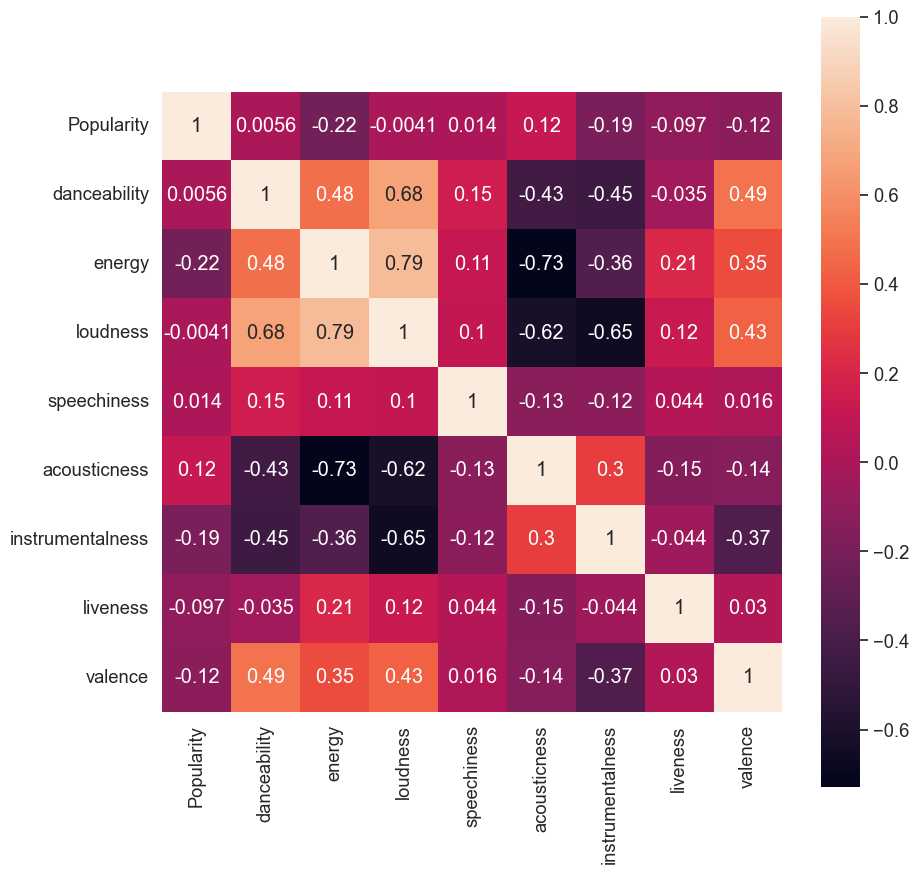

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Popularity', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

cor_matrix = filtered_df[features].corr()

plt.figure(figsize=(10,10))

sns.heatmap(cor_matrix, annot=True, square=True)
plt.show